In this pipeline, we will be training a simple DecisionTreeRegressor model on the Jarvis Dataset and implementing various unsupervised techniques to assess how variations in the data affect model performance. Those unsupervised learning techniques include KMEANS, outlier test, etc. 


## Preparing the Data

In [2]:
from jarvis.db.figshare import data
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
df = pd.DataFrame(data("dft_3d"))
df 

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.


,jid,spg_number,spg_symbol,formula,formation_energy_peratom,func,optb88vdw_bandgap,atoms,slme,magmom_oszicar,...,density,poisson,raw_files,nat,bulk_modulus_kv,shear_modulus_gv,mbj_bandgap,hse_gap,reference,search
0,JVASP-90856,129,P4/nmm,TiCuSiAs,-0.42762,OptB88vdW,0.000,"{'lattice_mat': [[3.566933224304235, 0.0, -0.0...",na,0.0,...,5.956,na,[],8,na,na,na,na,mp-1080455,-As-Cu-Si-Ti
1,JVASP-86097,221,Pm-3m,DyB6,-0.41596,OptB88vdW,0.000,"{'lattice_mat': [[4.089078911208881, 0.0, 0.0]...",na,0.0,...,5.522,na,"[OPT-LOPTICS,JVASP-86097.zip,https://ndownload...",7,na,na,na,na,mp-568319,-B-Dy
2,JVASP-64906,119,I-4m2,Be2OsRu,0.04847,OptB88vdW,0.000,"{'lattice_mat': [[-1.833590720595598, 1.833590...",na,0.0,...,10.960,na,"[OPT-LOPTICS,JVASP-64906.zip,https://ndownload...",4,na,na,na,na,auid-3eaf68dd483bf4f4,-Be-Os-Ru
3,JVASP-98225,14,P2_1/c,KBi,-0.44140,OptB88vdW,0.472,"{'lattice_mat': [[7.2963518353359165, 0.0, 0.0...",na,0.0,...,5.145,na,[],32,na,na,na,na,mp-31104,-Bi-K
4,JVASP-10,164,P-3m1,VSe2,-0.71026,OptB88vdW,0.000,"{'lattice_mat': [[1.6777483798834445, -2.90594...",na,0.0,...,5.718,0.23,"[FD-ELAST,JVASP-10.zip,https://ndownloader.fig...",3,48.79,33.05,0.0,na,mp-694,-Se-V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75988,JVASP-156020,139,I4/mmm,AcRh2Pb2,-0.30652,OptB88vdW,0.000,"{'lattice_mat': [[-2.374509402119681, 2.374509...",na,0.0,...,11.194,na,[],5,na,na,na,na,1206834,-Ac-Pb-Rh
75989,JVASP-156398,216,F-43m,PrTlZn,-0.34112,OptB88vdW,0.000,"{'lattice_mat': [[-0.0, 3.4210598347774503, 3....",na,0.0,...,8.517,na,[],3,na,na,na,na,915022,-Pr-Tl-Zn
75990,JVASP-156099,139,I4/mmm,BaIn2Bi2,-0.39352,OptB88vdW,0.000,"{'lattice_mat': [[4.082347574975881, -4.076131...",na,0.0,...,7.460,0.67,[],5,30.67,-11.44,na,na,1214095,-Ba-Bi-In
75991,JVASP-156007,139,I4/mmm,TmSi2Tc2,-0.54853,OptB88vdW,0.000,"{'lattice_mat': [[2.90400678672412, -2.9037689...",na,0.0,...,8.212,na,[],5,na,na,na,na,1206745,-Si-Tc-Tm


In [3]:
#Based on the Accelerated Discovery of Efficient Solar Cell Materials Using Quantum and Machine Learning Methods,
#we are interested in materials with SLME values > 10%
#remove the data that does not have SLME values
df_slme = df[~df['slme'].isin(["na","?"])].copy()
df_slme['slme'] = df_slme.loc[:,'slme'].astype(float)
df_slme["slme_10"] = (df_slme['slme'] >= 10.0).astype(int)
df_slme.replace({"na": np.nan, "?" : np.nan}, inplace=True)
# Remove uncessary columns
df_slme.drop(columns=['jid', 'atoms', 'elastic_tensor', 'effective_masses_300K', 'modes', 'icsd','efg', 'xml_data_link', 'raw_files', 'reference', 'search'], inplace=True)
print(f"Dataframe shape after removing entries with SLME <= 10%: {df_slme.shape}")




Dataframe shape after removing entries with SLME <= 10%: (9770, 54)


C:\Users\nitro\AppData\Local\Temp\ipykernel_23776\638729351.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_slme.replace({"na": np.nan, "?" : np.nan}, inplace=True)


In [4]:
# Convert columns to int/float as needed to avoid issues during modeling
col_convert_float = [ 'magmom_oszicar', 'spillage', 'maxdiff_mesh', 'maxdiff_bz', 'epsx', 'epsy', 'epsz',
    'mepsx', 'mepsy', 'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
    'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
    'dfpt_piezo_max_dielectric_electronic', 'dfpt_piezo_max_dielectric_ionic',
    'max_ir_mode', 'min_ir_mode', 'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact',
    'ncond', 'pcond', 'nkappa', 'pkappa', 'Tc_supercon', 'exfoliation_energy', 'poisson',
    'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap']

for col_name in col_convert_float:
    df_slme[col_name] = df_slme[col_name].fillna(0)
    df_slme.loc[:,col_name] = df_slme[col_name].astype(float)


df_slme.loc[:,'encut'] = df_slme['encut'].fillna(0).astype(int)
df_slme.loc[:,'kpoint_length_unit'] = df_slme['kpoint_length_unit'].fillna(0).astype(int)

print(df_slme.columns)

Index(['spg_number', 'spg_symbol', 'formula', 'formation_energy_peratom',
       'func', 'optb88vdw_bandgap', 'slme', 'magmom_oszicar', 'spillage',
       'kpoint_length_unit', 'maxdiff_mesh', 'maxdiff_bz', 'encut',
       'optb88vdw_total_energy', 'epsx', 'epsy', 'epsz', 'mepsx', 'mepsy',
       'mepsz', 'magmom_outcar', 'max_efg', 'avg_elec_mass', 'avg_hole_mass',
       'dfpt_piezo_max_eij', 'dfpt_piezo_max_dij', 'dfpt_piezo_max_dielectric',
       'dfpt_piezo_max_dielectric_electronic',
       'dfpt_piezo_max_dielectric_ionic', 'max_ir_mode', 'min_ir_mode',
       'n-Seebeck', 'p-Seebeck', 'n-powerfact', 'p-powerfact', 'ncond',
       'pcond', 'nkappa', 'pkappa', 'ehull', 'Tc_supercon', 'dimensionality',
       'typ', 'exfoliation_energy', 'spg', 'crys', 'density', 'poisson', 'nat',
       'bulk_modulus_kv', 'shear_modulus_gv', 'mbj_bandgap', 'hse_gap',
       'slme_10'],
      dtype='object')


## PCA Implementation

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [6]:
#Set target and remove target variables from features
y_pred_PCA = df_slme['slme']
X_features_PCA = df_slme.select_dtypes(include = ["number"]).drop(columns=['slme','slme_10'])
columns_ = X_features_PCA.columns
feature_columns = X_features_PCA.columns


In [ ]:
#standardise and impute features

simpler = SimpleImputer(strategy='mean')
X_features_PCA = simpler.fit_transform(X_features_PCA)

scaler = StandardScaler()
X_standard = scaler.fit_transform(X_features_PCA)




44


In [19]:
#PCA Implementation

pca_optim, pca_list, optimal_components, level_of_val, epsilon= PCA(n_components = 2), [], 0, 0, 0.001
pca_optim.fit(X_standard)

for i in range(0,X_standard.shape[1]):
    pca = PCA(n_components = i)
    pca.fit(X_standard)
    pca_list.append(pca)   
  
    if (pca.explained_variance_ratio_.sum() >= 0.95 and optimal_components == 0):
        #Transform the data using the optimal number of components
        pca_optim = pca
        
        optimal_components = i
        
    if (len(pca_list) >= 2 and pca_list[-1].explained_variance_ratio_.sum() - pca_list[-2].explained_variance_ratio_.sum() < epsilon): 
        level_of_val = pca_list[-1].explained_variance_ratio_.sum()
        print(f"Convergence reached at {i} components with {level_of_val} variance explained.")
        break
    
#Print explained variance ratio for each component 
print(f"Explained Variance List: \n{pca.explained_variance_ratio_}")
X_pca_transformed = pca_optim.transform(X_standard)
print(X_pca_transformed)




Convergence reached at 39 components with 0.9988779481218816 variance explained.
Explained Variance List: 
[0.15522802 0.08850578 0.07932105 0.06073929 0.04889593 0.04029041
 0.03962874 0.03799761 0.03345474 0.02875318 0.02810926 0.02718674
 0.02401043 0.02282025 0.02254649 0.0216074  0.02111506 0.02067253
 0.0192231  0.01871346 0.01740296 0.01625845 0.01452694 0.0139652
 0.01334125 0.01144775 0.01075634 0.00961442 0.00892477 0.00831591
 0.00647346 0.00622484 0.00533814 0.00443174 0.00353955 0.0033725
 0.00322142 0.00192301 0.00097981]
[[-1.57844102  0.7575733   1.42747888 ...  1.17448054  0.57776976
   0.32106148]
 [-1.27851649 -0.7334662  -2.02199959 ... -1.07553783 -0.70302939
  -0.27886095]
 [ 0.38541913  0.70139898  2.02362038 ... -1.48285178  0.87448341
   0.90618506]
 ...
 [ 3.62212243 -1.78988932 -0.52043776 ...  1.11510621  0.16312718
  -0.19178232]
 [ 3.71971447 -1.77341478 -0.43007684 ...  1.01302107  0.23909231
  -0.07234432]
 [ 2.16966757 -1.47388548 -1.30192217 ...  0.790

In [25]:
# Display the total contributions of each PCA component across the unique features 
X_pca_df = pd.DataFrame(pca_optim.components_, columns= columns_ , index = [f'PCA {i+1}' for i in range(pca_optim.n_components_) ] )
print(X_pca_df,"/n")


        formation_energy_peratom  optb88vdw_bandgap  magmom_oszicar  spillage  \
PCA 1                   0.148192          -0.232152        0.057706  0.152955   
PCA 2                  -0.082780           0.108575       -0.077895 -0.011887   
PCA 3                   0.001894          -0.008577       -0.058481  0.049195   
PCA 4                   0.344623          -0.253132       -0.114307  0.042294   
PCA 5                  -0.027263          -0.093978       -0.126851  0.032959   
PCA 6                   0.037004           0.056642        0.143965  0.169223   
PCA 7                  -0.085712          -0.217676        0.568427 -0.062685   
PCA 8                  -0.079710           0.004186       -0.162148  0.170273   
PCA 9                   0.095040           0.119908        0.130256 -0.065936   
PCA 10                 -0.063315           0.306879        0.101802 -0.032897   
PCA 11                 -0.248462           0.077896        0.002864 -0.056413   
PCA 12                  0.21

In [ ]:
# Features sorted by descending relative Importance
# Sum the absolute contribution of each component across all features 
total_contribution =  X_pca_df.abs().sum(axis = 0)
total_contribution = total_contribution.sort_values(ascending = False)
print(total_contribution)  

encut                                   4.858338
nat                                     4.768763
formation_energy_peratom                4.677356
density                                 4.636518
mbj_bandgap                             4.630338
avg_elec_mass                           4.556949
n-Seebeck                               4.521352
ehull                                   4.448998
avg_hole_mass                           4.284851
optb88vdw_total_energy                  4.275443
p-powerfact                             4.253665
n-powerfact                             4.228870
p-Seebeck                               4.228204
spillage                                4.212398
kpoint_length_unit                      4.191705
min_ir_mode                             4.168228
max_ir_mode                             4.107653
max_efg                                 4.057551
optb88vdw_bandgap                       3.950935
dfpt_piezo_max_dielectric_electronic    3.923584
dfpt_piezo_max_dij  

In [ ]:
#PCA transformed dataframe
X_PCA_points = pd.DataFrame(X_pca_transformed, columns = [f'PCA{i}' for i in range(pca_optim.n_components_)])
print(X_PCA_points)

          PCA0      PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0    -1.578441  0.757573  1.427479  2.673148 -2.442659 -1.170638  1.139596   
1    -1.278516 -0.733466 -2.022000 -0.496795 -0.031018 -0.045666 -0.106997   
2     0.385419  0.701399  2.023620  1.666831  0.681770  0.453400 -0.080079   
3     0.748167 -0.082557  0.145947 -0.649291  2.707778 -0.553107  0.362066   
4     0.179244 -1.238013 -1.838790  1.754982  0.596664  0.163367 -0.161796   
...        ...       ...       ...       ...       ...       ...       ...   
9765 -0.845356 -1.166476 -2.456854  0.719475 -0.180759 -0.003221 -0.550614   
9766  9.179060 -2.942027  1.033806 -1.562589 -2.434436 -1.103051 -2.059148   
9767  3.622122 -1.789889 -0.520438  0.370062  0.221913 -0.990414 -0.202619   
9768  3.719714 -1.773415 -0.430077  0.145556  0.279891 -1.010459 -0.145613   
9769  2.169668 -1.473885 -1.301922  0.077232 -0.594387 -0.003019 -1.311404   

          PCA7      PCA8      PCA9  ...     PCA19     PCA20    

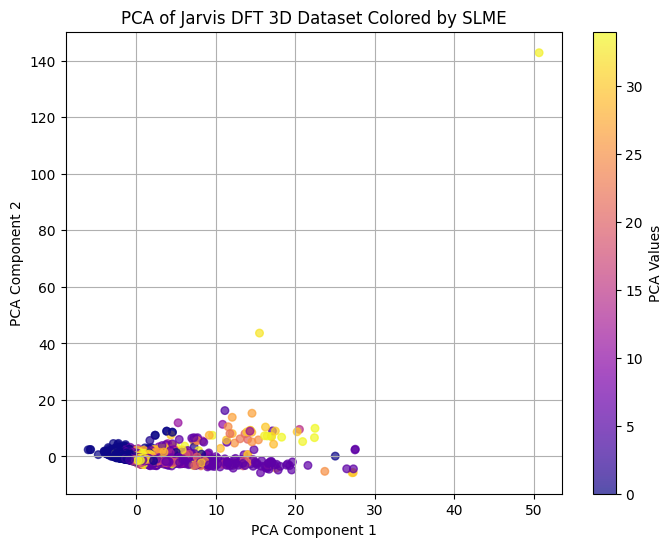

In [ ]:
# Scatter Plot of PCA Component 1 vs PCA Component 2
fig = plt.figure(figsize = (8,6))
#Scatter Plot
plt.scatter(X_pca_transformed[:,0], X_pca_transformed[:,1], c = y_pred_PCA, cmap='plasma', alpha=0.7, s= 30)

#Labels, Title, and Grid
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Jarvis DFT 3D Dataset Colored by SLME")
plt.grid()

color_bar = plt.colorbar()
color_bar.set_label("PCA Values")




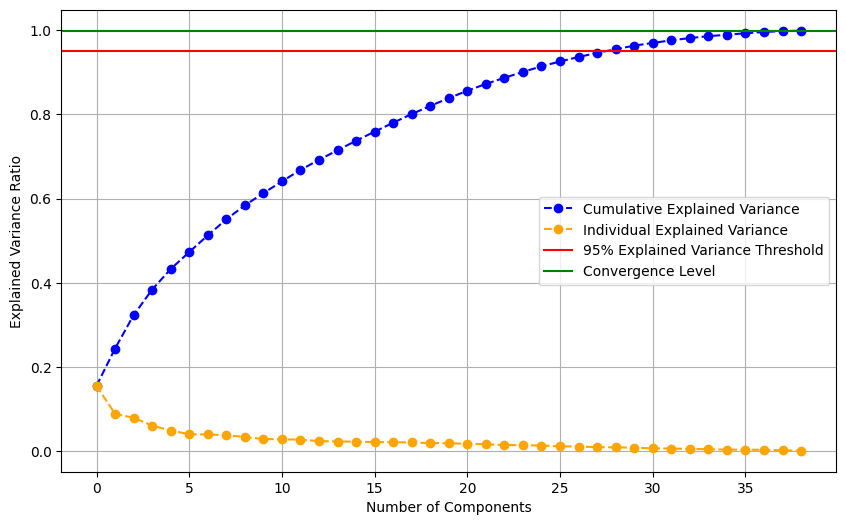

In [ ]:
#Assume PCA is the first PCA object where explained_variance_ratio converges

cummulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize  =(10,6))
#Scatter Plot
plt.plot(np.arange(0,pca.n_components_),cummulative_explained_variance, marker ='o', linestyle ='--', label = 'Cumulative Explained Variance', color='blue')
plt.plot(np.arange(0,pca.n_components_), pca.explained_variance_ratio_, marker ='o', linestyle ='--', color='orange', label = 'Individual Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
#Variance threshold
plt.axhline(y = 0.95, color = 'r', linestyle = '-', label='95% Explained Variance Threshold')
plt.axhline(y = level_of_val, color = 'g', linestyle = '-', label='Convergence Level')
plt.grid()
plt.legend( )



## Splitting the Data into Training and Testing Data
### 1. Encoding Techniques
We applied a basic label encoding technique to convert all categorical features into numerical forms. This preserves category distinctions while allowing numerical input for machine learning models.

To learn more, [visit this link](https://www.geeksforgeeks.org/machine-learning/ml-label-encoding-of-datasets-in-python/
)

In [ ]:
from prince import MCA
from sklearn.model_selection import train_test_split
import random

# Preparing the Data
df_categorical_columns = ['spg_number', 'spg_symbol', 'func', 'dimensionality', 'spg', 'crys', 'typ']

#Encoding Technique
for column in df_categorical_columns:
    df[column] = df[column].astype('category').cat.codes
    

#Split the Current Data into training and testing segments
X = df_slme.drop(columns = ['slme','slme_10','formula']).select_dtypes(include =["number"])
Y = df_slme['slme_10']
random_seed = random.randint(1,100)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_seed)
test_indices = Y_test.index




# Model Selection
## Decision Tree Regressor
Decision Tree Regressor models are machine learning algorithms that capture the significance of non - linear, continuous data by creating a tree-like structure based on inferred relationships between the data's features.

We chose this model for our pipeline because it can determine the relationships between continuous SLME-10 and other features in the Jarvis data set, while it's relative simplicity compared to LGBM makes it an effective baseline model. 

To learn more, [visit this link](https://farshadabdulazeez.medium.com/understanding-decision-tree-regressor-an-in-depth-intuition-a1d3af182efd)
    

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, log_loss, roc_auc_score


#Initialize the simple Tree
df_slme_regressor = DecisionTreeRegressor(max_depth  = 5)
#Train the model 
df_slme_regressor.fit(X_train, Y_train)

#Store the Predicted Slme_10 values for later analysis 
Y_pred = df_slme_regressor.predict(X_test)


results = pd.DataFrame({"Formula":df_slme.loc[test_indices, "formula"], "Actual": Y_test, "Predicted": Y_pred.astype(int)})
results.index = [i for i in range(results.shape[0])]

#Display the Results of Training a simple DecisionTreeRegressor 
   
print("Number of materials:", results.shape[0])
print("Number of Suitable materials:", results["Actual"].sum(axis = 0))
print("Number of Predicted materials: ",results["Predicted"].sum(axis = 0))
print("Accuracy Score: ", accuracy_score(results["Actual"], results["Predicted"].round()))
print("ROC AUC Score: ", roc_auc_score(results["Actual"], results["Predicted"]))

print(results)



Number of materials: 1954
Number of Suitable materials: 811
Number of Predicted materials:  747
Accuracy Score:  0.9672466734902764
ROC AUC Score:  0.9605425400739828
         Formula  Actual  Predicted
0       BaAl2Te4       1          1
1        Yb2ZnPb       0          0
2     SrLi2Nb2O7       1          1
3       Rb2Sb4S7       0          0
4        Tl2SiF6       0          0
...          ...     ...        ...
1949    HoMoClO4       0          0
1950     Ca3CdO4       0          0
1951   Mo2WSe4S2       1          1
1952     CaBi4O8       1          1
1953      BeSiN2       0          0

[1954 rows x 3 columns]


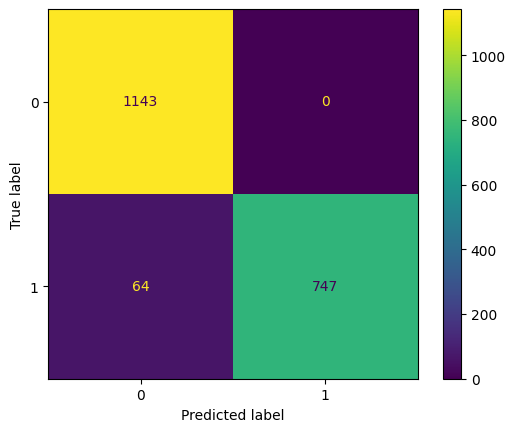

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay.from_predictions(Y_test,Y_pred.astype(int))
plt.show()

# Kmeans, an Unsupervised Learning Technique

Kmeans is a learning technique that splits existing data sets into an arbitrary amount of subgroups. If there are $N$ distinct groups, then each subgroup $S$ has the defining property that for all $P \in S$, there exists a central point $C_i$, where $1 \le i \le n$ (these are called centroids), such that $\|P-C_i\| \le \epsilon$. In other words, each Kmeans subgroup is defined by a unique neighborhood about their corresponding centroids.

We are using Kmeans to determine if there is any significant difference in model performance across different subgroups of our data.

In [ ]:
# Unsupervised beginning implementation
from k_means_constrained import KMeansConstrained as KMeans
import numpy as np

# Forces every element of df_cluster to be numeric
df_cluster= df_slme.select_dtypes(include = ["number"])
#Kmeans Implemented for seven clusters, or groups
num_points = df_cluster.shape[0]
optim_size = num_points//7
kmeans = KMeans(n_clusters = 7, size_min = optim_size , random_state = 42,  n_init = 50)
kmeans.fit_transform(df_cluster)
labels = kmeans.labels_
df_slme["labels"] = labels




# Seven Kmeans Clusters
labels_df = pd.DataFrame({"formula":df_slme["formula"], "label": df_slme["labels"]})

print(labels_df)
df_cluster_list = [df_slme[df_slme["labels"] == i] for i in range(0,7)]

for df_cluster in df_cluster_list:
    print(df_cluster)
    print("\n")



c:\Users\nitro\AppData\Local\Programs\Python\Python313\Lib\site-packages\k_means_constrained\k_means_constrained_.py:464: RuntimeWarning: invalid value encountered in cast
  costs = np.around(costs * 1000, 0).astype('int32')  # Times by 1000 to give extra precision


        formula  label
20     PdSe8Cl2      5
23       LiSbF6      3
24         AlAs      3
25         SrB6      3
26          SiS      3
...         ...    ...
75345     Li4HN      6
75566    PmCdGa      6
75593    HfInAu      6
75961    HfPdPb      6
75972  NaMg2Sb2      6

[9770 rows x 2 columns]
      spg_number spg_symbol    formula  formation_energy_peratom       func  \
33151         59       Pmmn      TeMoS                  -0.57919  OptB88vdW   
33153        139     I4/mmm    Bi2SeO2                  -1.10048  OptB88vdW   
33158        227      Fd-3m    Cd2SiO4                  -1.85174  OptB88vdW   
33177        180     P6_222       SiO2                  -2.88415  OptB88vdW   
33187         12       C2/m  TbBa2BiO6                  -2.64133  OptB88vdW   
...          ...        ...        ...                       ...        ...   
40259        121      I-42m     K3TaO8                  -1.61258  OptB88vdW   
40263         15       C2/c  SrH4Cl2O2                  -1.56731  O

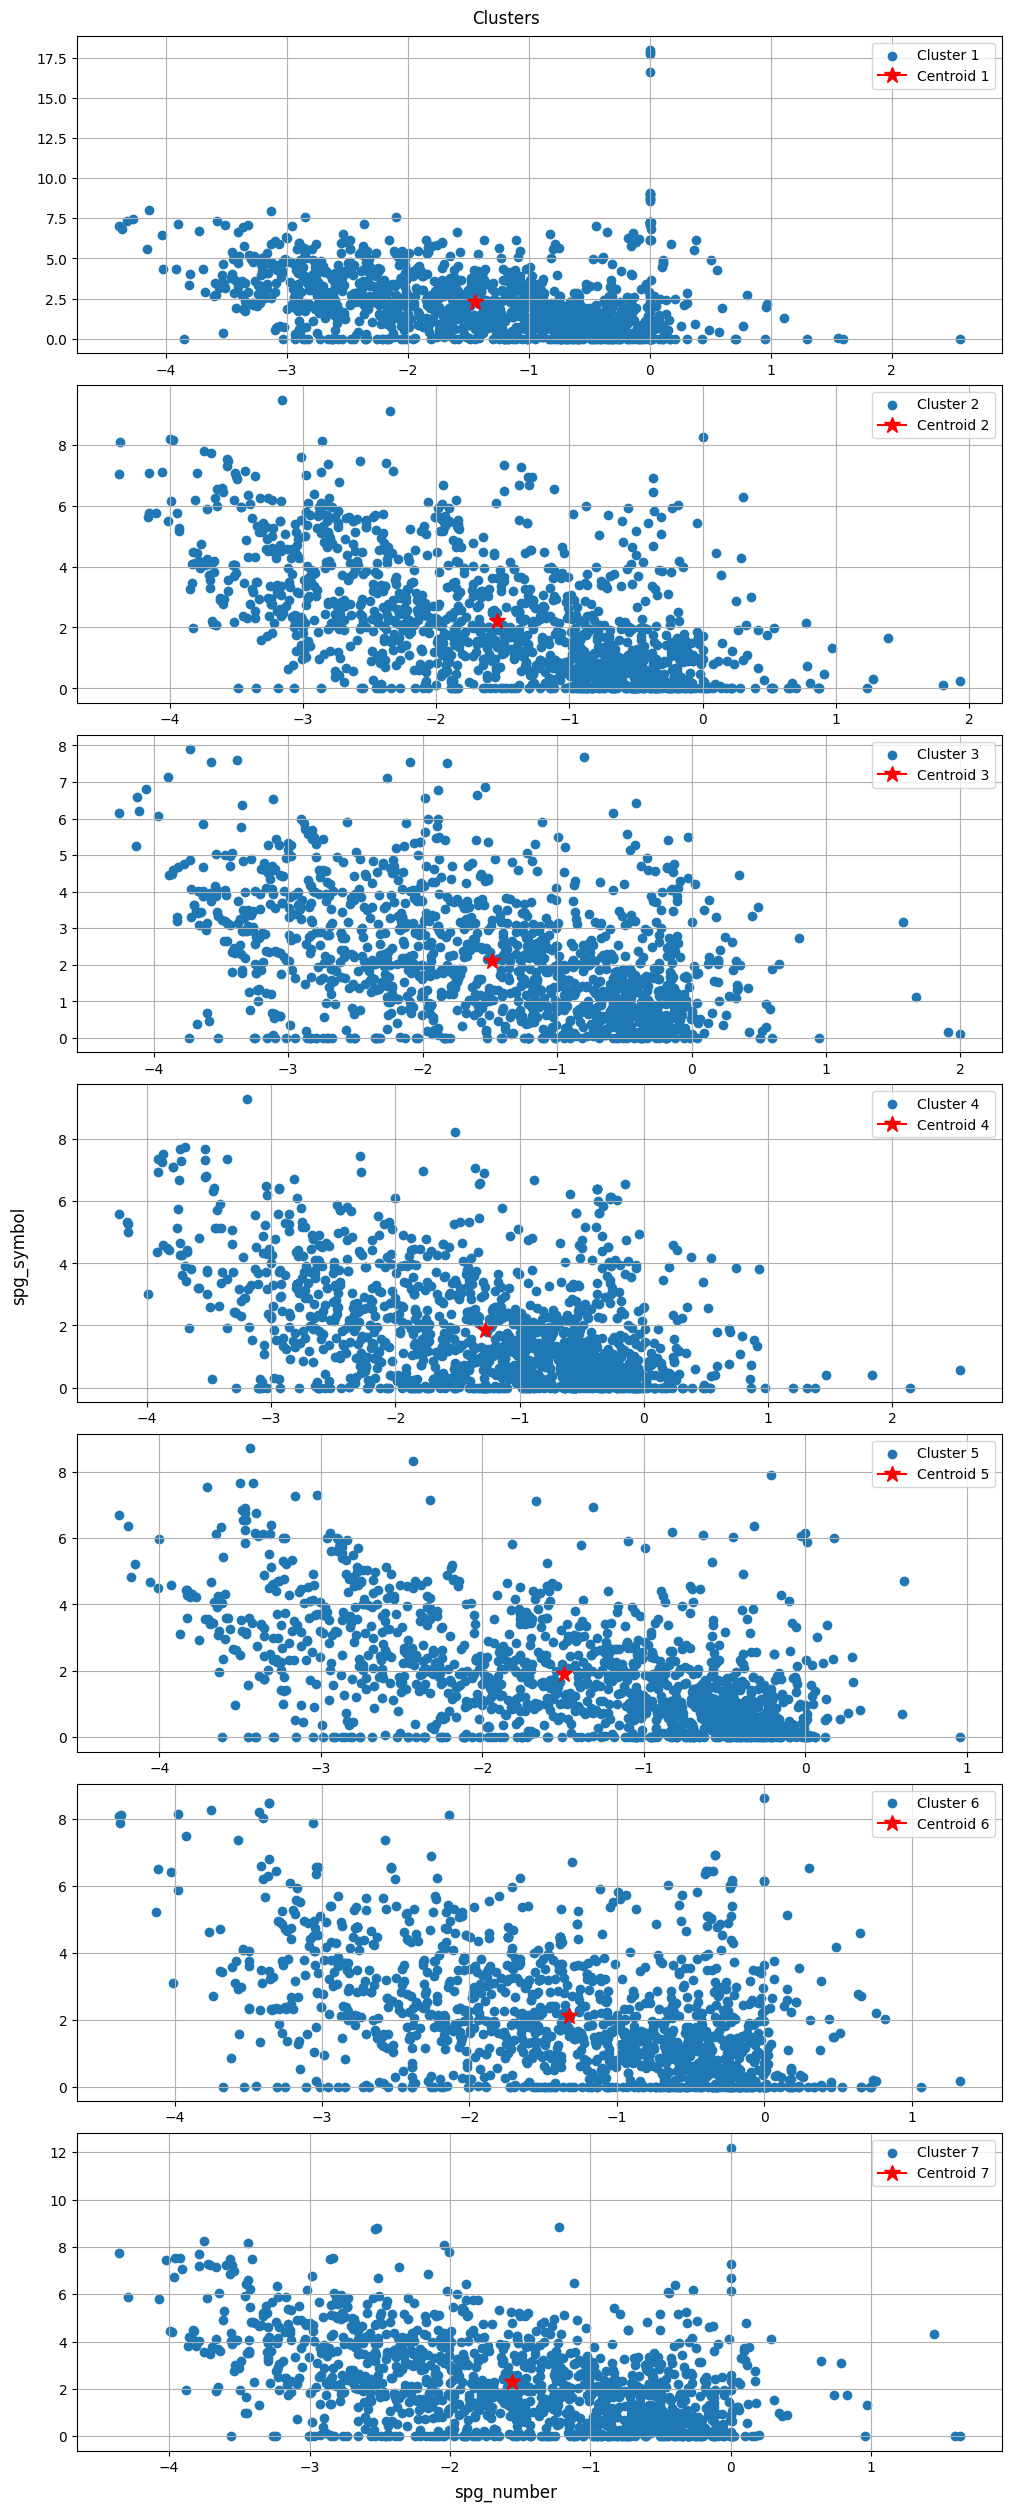

In [ ]:


#Plotting each Cluster with the Centroid Clearly Shown
fig,axs = plt.subplots(nrows = 7, ncols = 1,constrained_layout = True)
centroids_X = kmeans.cluster_centers_[:,0]
centroids_Y = kmeans.cluster_centers_[:,1]  
fig.set_size_inches(10, 25)
fig.supxlabel(df_cluster.columns[0])
fig.supylabel(df_cluster.columns[1])
fig.suptitle("Clusters")


for i in range(len(axs)):
    cluster = df_cluster_list[i]
    scatter_i = axs[i].scatter(cluster.select_dtypes(include = ["number"]).iloc[:,0],
                      cluster.select_dtypes(include = ["number"]).iloc[:,1],
                      label = f"Cluster {i+1}")
    centroid_i = axs[i].plot(centroids_X[i],centroids_Y[i], marker = "*", color = "red", markersize = 12, label = f"Centroid {i+1}")
    axs[i].grid()
    axs[i].legend()
    






In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
import random

def train_cluster(df_cluster):
    
    
    X = df_cluster.select_dtypes(include = ["number"]).drop(columns = ["slme", "slme_10","labels"])
    Y = df_cluster["slme_10"]
    rand = random.randint(1,100)
    X_train,X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = rand)
    
    indices = Y_test.index
    
    df_slme_regressor.fit(X_train,Y_train)
    
    Y_pred = df_slme_regressor.predict(X_test)


    result = pd.DataFrame({"formula": df_cluster.loc[indices,"formula"], "Actual": Y_test, "Predicted": (Y_pred>0.5).astype(int)})
    result.index = [i+1 for i in range(0,len(result))]
    num_materials = len(result)
    num_suitable_materials = result["Predicted"].sum(axis = 0)
    accuracy = accuracy_score(result["Actual"],result["Predicted"])
    

    return result, num_materials, num_suitable_materials, accuracy


for i in range(len(df_cluster_list)):
    cluster = df_cluster_list[i]
    result, num_materials, num_suitable_materials, accuracy = train_cluster(cluster)
    print (f"======== Cluster {i} results ========")
    print(result, "\n\n")
    print("Number of total materials:", len(result))
    print("Number of Predicted suitable materials: ", num_suitable_materials)
    print("Number of Acutal suitable materials: ",result["Actual"].sum(axis = 0) )
    print("Accuracy", accuracy, "\n")
    


======== Cluster 0 results ========
        formula  Actual  Predicted
1         CdPS3       0          0
2       MgCo2O4       0          0
3         CdBr2       0          0
4       KLiZnO2       0          0
5       NbS2Cl2       1          1
..          ...     ...        ...
276       AlVPt       0          0
277    Tb2Be2O5       0          0
278         BAs       1          1
279  Rb2NaBiCl6       0          0
280       ErVO4       0          0

[280 rows x 3 columns] 


Number of total materials: 280
Number of Predicted suitable materials:  106
Number of Acutal suitable materials:  107
Accuracy 0.9892857142857143 

======== Cluster 1 results ========
       formula  Actual  Predicted
1          InP       1          1
2         TiO2       0          0
3    TiZnBi2O6       1          1
4       NdTeCl       1          1
5      Cd3TeO6       1          1
..         ...     ...        ...
275      LiHF2       1          0
276      In2S3       1          1
277      AlWO4       1     